# Rothamsted Spinup
This notebook runs the whole spinup for the Rothamsted site, including:
1. Pre-BG spinup
2. BG spinup
3. Full spinup

## 0. Setup
The following cells are useful to run, also before other stages of the spinup

In [102]:
clear all;
% Add T&C Code directory to path so we don't need to navigate between folders from *within* the scripts
addpath("T&C_CODE");

% Make sure this is the root folder of this project
root_dir = cd;
% Descriptor will be saved with all other variables and can be helpful to reconstruct what has been done
descriptor = "Set NPK reserves at planting such that there should be just no nutrient constrains, but not much higher";
% Some more information to compose the name of this experiment
short_descriptor = 'porg006';
timestamp = datestr(now, "yy-mm-dd-HHMM");
id_location = 'Rothamsted';
run_identifier = [timestamp '_' id_location '_' short_descriptor];

% Location of parameters to be used in multiple stages of the spinup
param_filename = ['MOD_PARAM_' id_location '_Spinup_common'];
PARAM_IC = [root_dir filesep 'PARAMETER_PLOT_FILES' filesep param_filename];

## 1. Pre-BG Spinup

As a first step we run the spinup without the biogeochemistry module activated. For this we will use a truncated version of the prova-file, which does not specify the paths of the parameter and output files. We will do so ourselves and then call the main routine `MAIN_FRAME` directly from this notebook.

In [103]:
% Run truncated prova file to perform standard initialization
run("PARAMETER_PLOT_FILES\prova_Rothamsted_Spinup");

%%%%%%%%%%%%%%%%%%%%%%%%%%%%
MAIN_FRAME ;
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% cd(current_directory);
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
initial_spinup_results_folder = ['results' filesep 'initial_spinup'];
mkdir(initial_spinup_results_folder);
initial_spinup_result_fn = [run_identifier '.mat'];
initial_spinup_results_path = [initial_spinup_results_folder filesep initial_spinup_result_fn];
save(initial_spinup_results_path);

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.

Iter:
     2

Iter:
        1000

Iter:
        2000

Iter:
        3000

Iter:
        4000

Iter:
        5000

Iter:
        6000

Iter:
        7000

Iter:
        8000

Iter:
        9000

Iter:
       10000

Iter:
       11000

Iter:
       12000

Iter:
       13000

Iter:
       14000

Iter:
       15000

Iter:
       16000

Iter:
       17000

Iter:
       18000

Iter:
       19000

Iter:
       20000

Iter:
       21000

Iter:
       22000

Iter:
       23000

Iter:
       24000

Iter:
       25000

Iter:
       26000

Iter:
       27000

Iter:
       28000

Iter:
       29000

Iter:
       30000

Iter:
       31000

Iter:
       32000

Iter:
       33000

Iter:
       34000

Iter:
       35000

Iter:
       36000

Iter:
       37000

Iter:
       38000

Iter:
       39000

Iter:
       40000

Iter:
       41000

Iter:
       42000

Iter:
       43000

Iter:
       44000

Iter:
       45000

Iter:
       46000

Iter:
       47000

Iter:
       48000

Iter:
       49000

Iter:


### 1.1 Calibration

Here, we can compare some of the model outputs, such as yield with recorded field values to get an idea if it matches. If not, the spinup should be repeated with modified parameters.
We will start by calculating the total simulated straw and grain yields per year.

In [ ]:
% Run this cell to load data from a previous spinup
initial_spinup_results_path = ['results' filesep 'initial_spinup' filesep '25-04-23-1817_Rothamsted_npk_res_ini_35_05_15.mat'];
load(initial_spinup_results_path);

In [104]:
% Setting this true means that negative `RB` values at planting will not be counted to yield
OPT_only_positive_yield = true;

years_daily = Datam(1:24:end,1); %! Year for each day of the simulation (Datam is in h, hence only every 24th)
years = unique(years_daily);
years = years(2:end); % Ignore first year, which has no harvest
yield_yearly_pred = zeros(length(years), cc, 7);
for i=1:length(years)
    yr = years(i);
    RB_L_curr_yr = RB_L(years_daily==yr, :, :);
    if OPT_only_positive_yield
        RB_L_curr_yr(RB_L_curr_yr < 0) = 0;
    end
    yield_yearly_pred(i, :, :) = sum(RB_L_curr_yr, 1);
end
grain_yearly_pred = sum(yield_yearly_pred(:, :, [4, 5]), 3); %! Grains are fruit (5) and C reserve (4) compartments
straw_yearly_pred = sum(yield_yearly_pred(:, :, [1, 2, 7]), 3); %! Straw is leaves (1), sapwood (2), and dead leaves (7) compartments

In [105]:
relevant_strip = 21;  %! Strip 3: No fertilizer, 21 (=2.1): Most fertilizer, highest yield
crop_data = readtable(['data' filesep 'Rothamsted_yield_data.csv']);
crop_data = crop_data((crop_data.section == relevant_section) & (crop_data.strip == relevant_strip), :);

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.

To compare with the reported yields from the field, we need to make sure that the units match (gC/m^2 vs. t/ha, where t is tons of 85% dry matter, and C content of dry matter is about 45% for grain and straw).

In [106]:
grain_yearly_obs = zeros(length(years), 1);
straw_yearly_obs = zeros(length(years), 1);
obs_dry_matter = 0.8;
c_content_grain = 0.45;
c_content_straw = 0.45;
grain_conversion_factor = obs_dry_matter * c_content_grain * 1e2;  %! from t/ha to gC/m^2
straw_conversion_factor = obs_dry_matter * c_content_straw * 1e2;  %! from t/ha to gC/m^2
for i=1:length(years)
    yr = years(i);
    grain_yearly_obs(i) = crop_data.grain(crop_data.harvest_year==yr) * grain_conversion_factor;
    straw_yearly_obs(i) = crop_data.straw(crop_data.harvest_year==yr) * straw_conversion_factor;
end

In [107]:
disp(['Mean grain yields - observed: ' num2str(mean(grain_yearly_obs)) ' , predicted: ' num2str(mean(grain_yearly_pred))])
disp(['Mean straw yields - observed: ' num2str(mean(straw_yearly_obs)) ' , predicted: ' num2str(mean(straw_yearly_pred))])

Mean grain yields - observed: 260.04 , predicted: 259.6078
Mean straw yields - observed: 230.64 , predicted: 152.9091


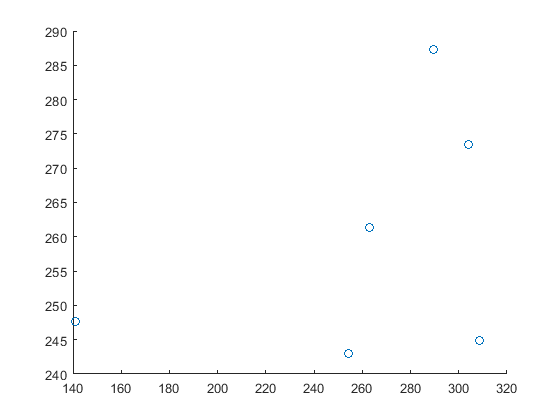

In [108]:
figure
scatter(grain_yearly_obs, grain_yearly_pred)

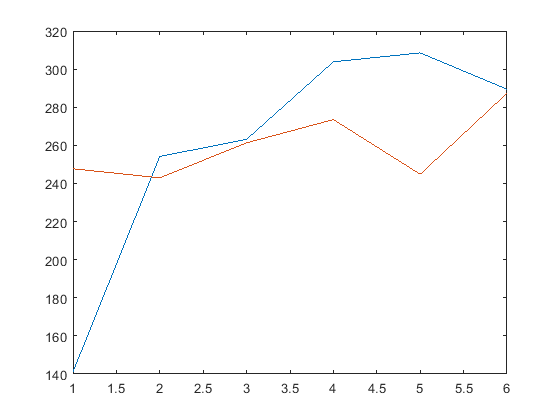

In [109]:
figure
plot(grain_yearly_obs)
hold on
plot(grain_yearly_pred)

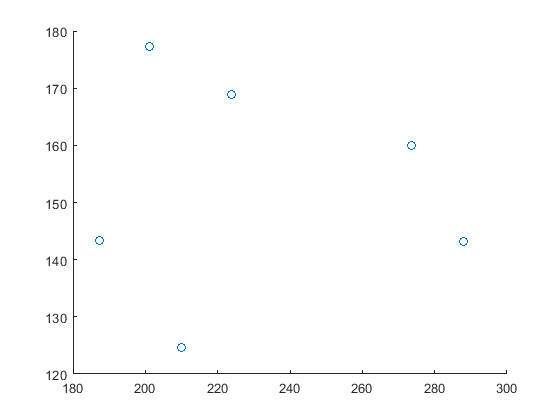

In [110]:
figure
scatter(straw_yearly_obs, straw_yearly_pred)
hold on
scatter(straw_yearly_obs(10:end), straw_yearly_pred(10:end))

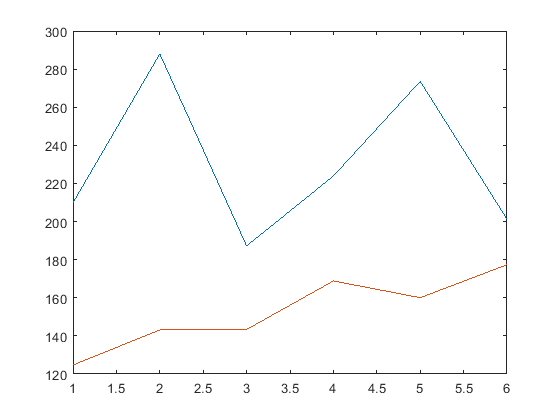

In [111]:
figure
plot(straw_yearly_obs)
hold on
plot(straw_yearly_pred)

## 2. BG Spinup

Now we will run the biogeochemistry spinup in isolation from the rest, for bouts of 100 years at once, and repeat that until the values for the BG pools remain relatively constant.

First we will add a folder to the matlab path that has a few functions defined that we will use here. We will also add the 'T&C_CODE' folder, to make sure it is still on the path.

In [112]:
addpath("biogeochemistry_spinup_functions");
addpath("T&C_CODE");

### 2.1. Load results from spinup

In [ ]:
load(initial_spinup_results_path);

#### 2.1.a If simulations include woody vegetation
If your vegetation includes wook, you will have to derive the wood turnover coefficient (`Wm_H` and/or `Wm_L`) after the first spinup. You should then run a second spinup with the parameter file containing the correct values for this coefficient. See Simone Fatichi's tutorial video for details.

### 2.2. Run biogeochemistry spinup

The biogeochemistry spinup will run in multiple epochs. At each epoch the spinup continues from the previous state for a given number of years (`Nyears_epoch`). The spinup ends, if at the end of an epoch the value of none of the biogeochemistry pools has changed more than a given percentage (`rtol`), or if the maximum number of epochs (`N_epochs_max`) is reached.

Below, we define the parameters mentioned above, as well as the path to the file holding deposition data.

In [ ]:
pwd

In [113]:
Nyears_epoch = 100;
N_epochs_max = 100;
%! If none of the pools changes more than 5% or 1e-4 during an epoch, the spinup ends
rtol = 0.05;
atol = 1e-4;
path_deposition_data = ['data' 'Inputs' 'All_deposition_data.mat'];
manure_data_path = [root_dir filesep 'data' filesep 'Rothamsted_manure_data.csv'];
OPT_Use_Fertilizer = true;
bg_save_folder = ['results' filesep 'bg_spinup' filesep run_identifier];
mkdir(bg_save_folder);

% Preprocessing - Function arguments are from initial spinup
[Se, Se_fc, Psi_s, Ts, V, VT] = bg_preprocess(Ta, Tdp, O, V, Soil_Param, Phy, SPAR, Bio_Zs);

License checkout failed.
License Manager Error 4410
Invalid security token. (Status code: Unauthorized)

Troubleshoot this issue by visiting: 
https://www.mathworks.com/support/lme/4410

Diagnostic Information:
Feature: MATLAB 
License path:  
Licensing error: 4410,0.

Error in bg_preprocess (line 12)
    Se = (log(nanmean(Aew)/0.000008575)/11.67)*Se_fc;

In [ ]:
% The actual spinup
[B, R_litter, R_litter_sur, R_microbe, R_bacteria, R_ew, VOL, BfixN, Min_N, Min_P, RmycAM, RmycEM, ...
    N2flx, NH4_Uptake, NO3_Uptake, P_Uptake, K_Uptake, LEAK_NH4, LEAK_NO3, LEAK_P, LEAK_K, LEAK_DOC, ...
    LEAK_DON, LEAK_DOP, Lk] = bg_spinup(Lat, Lon, N_epochs_max, Nyears_epoch, ISOIL_H+ISOIL_L, Zbio, rsd, ...
    Pcla, Psan, PHs, Zs, Ts, Ta, Psi_s, Se, Se_fc, V, VT, T_L, T_H, Lk, RexmyI, Ccrown, B_H+B_L, rtol, atol, bg_save_folder, ...
    dateNum1, crop_data, manure_data_path, OPT_Use_Fertilizer);

% Plot results of final epoch (states should not change significantly anymore)
bg_plot(B, R_litter, R_litter_sur, R_microbe, R_bacteria, R_ew, VOL, BfixN, Min_N, Min_P, RmycAM, RmycEM, ...
    N2flx, NH4_Uptake, NO3_Uptake, P_Uptake, K_Uptake, LEAK_NH4, LEAK_NO3, LEAK_P, LEAK_K, LEAK_DOC, ...
    LEAK_DON, LEAK_DOP, Lk, Zbio, rsd);

### 2.3. Export relevant variables
Finally, we save the final state of the biogeochemistry nutrient pools.

In [ ]:
B_end = B(end, :);
bg_save_path_final = [bg_save_folder filesep 'final.mat'];
save(bg_save_path_final, "B_end");

## 3 Full spin-up

In [115]:
% Run this cell to load data from previous spin up runs
clearvars

root_dir = cd;
id_location = 'Rothamsted';
% timestamp = '25-04-23-1817';
timestamp = '25-05-08-1003';
short_descriptor = 'porg006';
run_identifier = [timestamp '_' id_location '_' short_descriptor];

initial_spinup_results_path = ['results' filesep 'initial_spinup' filesep run_identifier];
% bg_save_path_final = ['results' filesep 'bg_spinup' filesep '25-04-23-1538_final.mat'];
bg_save_path_final = ['results' filesep 'bg_spinup' filesep run_identifier filesep 'final.mat'];

% Location of parameters to be used in multiple stages of the spinup
param_filename = ['MOD_PARAM_' id_location '_Spinup_common'];
PARAM_IC = [root_dir filesep 'PARAMETER_PLOT_FILES' filesep param_filename];

addpath("T&C_CODE");

In [98]:
% ..alternatively run this cell to make sure the work space is clean
clearvars -except initial_spinup_results_path bg_save_path_final PARAM_IC root_dir

In [116]:
prev_data = load(initial_spinup_results_path);
prev_bg = load(bg_save_path_final).B_end;

% Run truncated prova file to perform standard initialization
run("PARAMETER_PLOT_FILES\prova_Rothamsted_Spinup");
OPT_BG = 1;

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
initial_parameters_path = PARAM_IC;
PARAM_IC = [root_dir filesep 'PARAMETER_PLOT_FILES' filesep 'MOD_PARAM_Rothamsted_bg'];
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
MAIN_FRAME
%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Unrecognized function or variable 'OPT_Use_Fertilizer'.nal column headers as table variable names.

Error in MOD_PARAM_Rothamsted_bg (line 53)
B_IO = load_fertilizer(B_IO, dateNum1, NNd, crop_data, manure_data_path, OPT_Use_Fertilizer);

Error in run (line 112)
evalin('caller', strcat(scriptStem, ';'));

Error in MAIN_FRAME (line 222)
run(PARAM_IC);

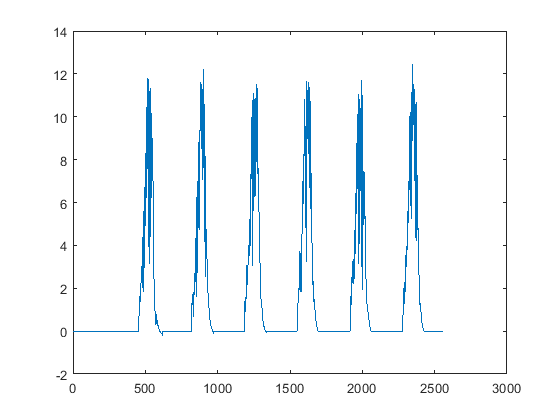

In [100]:
plot(NPP_L)

In [16]:
descriptor_full = "Full spinup providing initial NPK reserve 35(N), 5(P) and 15(K), fertilizer as in Rothamsted Strip 2.1 with N2 and manure. However, in Veg dyn res, nutrient exports `TexN/P/K` use a rN/P/Kc that is limited to at most 2";
%descriptor_full = "Full spinup providing initial NPK reserve 2(N), 0(P) and 1(K), fertilizer as in Rothamsted Strip 2.1 with N2 and manure";
% short_descriptor_full = 'limit_rNPKc';
short_descriptor_full = 'npk_res_ini_0_0_0_fert_like_field';
run_identifier_full = [run_identifier '_' short_descriptor_full];

In [17]:
full_spinup_folder = [root_dir filesep 'results' filesep 'full_spinup'];
mkdir(full_spinup_folder);
save_path = [full_spinup_folder filesep run_identifier_full '.mat'];
save(save_path);